In [14]:
!pip install PyTDC
!pip install PyTDC --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 10.8 MB/s 
     |████████████████████████████████| 29.3 MB 1.3 MB/s 
  Created wheel for PyTDC: filename=PyTDC-0.3.8-py3-none-any.whl size=136139 sha256=6715902813f5a56e06e9984f831463cddd6019ed814299cd7c8b0f0a5a51e3a7
  Stored in directory: /root/.cache/pip/wheels/4a/4f/da/b494dde823e311675b3ce778ca8c22e734ef8f779dbf311805
Successfully built PyTDC
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import sys
import numpy as np
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from tdc.benchmark_group import admet_group
!pip install deepchem
import torch
import deepchem as dc
from sklearn import metrics
import matplotlib.pyplot as plt
!pip install plot-metric


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 693 kB 29.5 MB/s 
     |████████████████████████████████| 29.3 MB 1.1 MB/s 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from tdc.single_pred import ADME
data = ADME(name = 'HIA_Hou')
print(data)

Found local copy...
Loading...
Done!


In [27]:
split = data.get_split(method = 'scaffold')
# get the entire data in the various formats
data.get_data(format = 'df')

100%|██████████| 578/578 [00:00<00:00, 3241.52it/s]


,Drug_ID,Drug,Y
0,Acetanilide,CC(=O)Nc1ccccc1,1
1,Acetazolamide.mol,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1
2,Alfacalcidol,C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]2CC[C@H]3[C@@H...,1
3,Aminopyrine,Cc1c(N(C)C)c(=N)n(-c2ccccc2)n1C,1
4,Amosulalol.mol,COc1ccccc1OCCNC[C@@H](O)c1ccc(C)cc1S(N)(=O)=O,1
...,...,...,...
573,Tiludronic_acid,O=P(O)(O)C(Cc1ccc(Cl)cc1)P(=O)(O)O,0
574,Zanamivir.mol,CC(=O)N[C@H]1[C@@H]([C@@H](O)[C@H](O)CO)OC(C(=...,0
575,Kanamycin.mol,CC(=O)NC[C@@H]1O[C@@H](O[C@H]2[C@@H](N)C[C@H](...,0
576,Amikacin.mol,NCC[C@@H](O)C(=O)N[C@@H]1C[C@H](N)[C@H](O[C@@H...,0


In [28]:
train = split['train']
val = split['valid']
test = split['test']

In [29]:
featurizer = dc.feat.CircularFingerprint(size=64, radius=4) #Use deepcghem for featurization
train_feat = featurizer.featurize(train['Drug'])
test_feat = featurizer.featurize(test['Drug'])
print(train_feat.shape)
print(test_feat.shape)

(404, 64)
(117, 64)


In [30]:
test_Y = np.array(test['Y'])
print(test_Y.shape)

(117,)


In [41]:
#model config
params = {
    "n_estimators": [50, 100, 200, 500, 1000],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 1, 5, 10],
    "reg_lambda": [0, 0.1, 1, 5, 10],
    "min_child_weight": [1, 3, 5]
}


from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic') #gradient boosting algorithm

clf = RandomizedSearchCV(
    estimator=xgb, param_distributions=params,
    scoring='roc_auc', n_iter=300
)

clf.fit(train_feat, np.array(list(train['Y']))) #fit the model


RandomizedSearchCV(estimator=XGBClassifier(learning_rate=1, max_depth=2,
                                           n_estimators=2),
                   n_iter=300,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [50, 100, 200, 500,
                                                         1000],
                                        'reg_alpha': [0, 0.1, 1, 5, 10],
                                        'reg_lambda': [0, 0.1, 1, 5, 10],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                

In [44]:
# print best parameters
best_params = clf.best_params_
print("Best parameters: ",best_params)
preds = clf.predict(test_feat)
print(preds)

Best parameters:  {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


Accuracy: 0.7692307692307693
TP,TN,FP,FN: 88 2 25 2
Precision: 0.7787610619469026
Recall: 0.9777777777777777
AUC: 0.5259259259259259


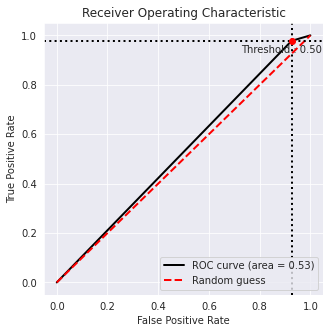

In [45]:
from plot_metric.functions import BinaryClassification
import pandas as pd
y = np.array(list(test['Y']))
y_hat = np.array(preds)

print("Accuracy:", np.sum(y == y_hat)/len(y))

fpr, tpr, thresholds = metrics.roc_curve(y,y_hat, pos_label=1)

df = {'y':y, 'y_hat':y_hat}
df = pd.DataFrame(df)
TP = sum(((df['y'] == 1) & (df['y_hat'] ==1)))
TN = sum(((df['y'] == 0) & (df['y_hat'] ==0)))
FP = sum(((df['y'] == 0) & (df['y_hat'] ==1)))
FN = sum(((df['y'] == 1) & (df['y_hat'] ==0)))
print("TP,TN,FP,FN:",TP,TN,FP,FN)

print("Precision:", TP/(TP+FP))
print("Recall:", TP/(TP+FN))
print("AUC:",metrics.auc(fpr, tpr))


bc = BinaryClassification(y, y_hat, labels=["Class 1", "Class 2"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

# Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

X_train = train_feat
y_train = np.array(list(train['Y']))
X_test = test_feat
y_test = np.array(list(test['Y']))

clf = RandomForestClassifier(n_estimators=50, random_state=23)
model = clf.fit(X_train, y_train)

# Use predict_proba to predict probability of the class
y_pred = clf.predict_proba(X_test)[:,1]

Accuracy: 0.7606837606837606
TP,TN,FP,FN: 88 1 26 2
Precision: 0.7719298245614035
Recall: 0.9777777777777777
AUC: 0.5074074074074074


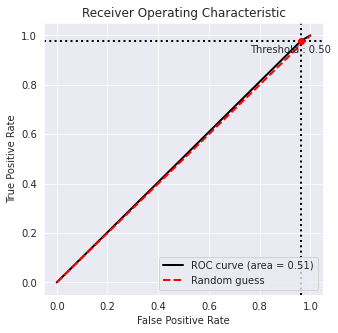

In [40]:
print("Accuracy:", np.sum(y == y_hat)/len(y))

fpr, tpr, thresholds = metrics.roc_curve(y,y_hat, pos_label=1)

df = {'y':y, 'y_hat':y_hat}
df = pd.DataFrame(df)
TP = sum(((df['y'] == 1) & (df['y_hat'] ==1)))
TN = sum(((df['y'] == 0) & (df['y_hat'] ==0)))
FP = sum(((df['y'] == 0) & (df['y_hat'] ==1)))
FN = sum(((df['y'] == 1) & (df['y_hat'] ==0)))
print("TP,TN,FP,FN:",TP,TN,FP,FN)

print("Precision:", TP/(TP+FP))
print("Recall:", TP/(TP+FN))
print("AUC:",metrics.auc(fpr, tpr))


bc = BinaryClassification(y, y_hat, labels=["Class 1", "Class 2"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()